# Two-level AMG+ for 1D Helmholtz / Repetitive
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.
* $A^c = P^T A Q$ is constructed locally and tiled, so that there is no fill-in due to $P$ in $P^T A P$.

In [96]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [129]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]

repetitive = True

# Test vectors.
ideal_tv = True #. False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 2
# Set # sweeps manually here.
num_sweeps_on_vectors = 1000 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513016


## Level 0->1 Coarsening

In [130]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.316e+00                    4.468e-01    2.940
INFO     1     7.242e-01 (0.551) [0.551]    3.424e-01    2.116 (0.719)
INFO     2     4.219e-01 (0.584) [0.567]    2.936e-01    1.441 (0.681)
INFO     3     2.655e-01 (0.630) [0.588]    2.686e-01    0.993 (0.689)
INFO     4     1.829e-01 (0.689) [0.612]    2.537e-01    0.724 (0.730)
INFO     5     1.382e-01 (0.756) [0.638]    2.437e-01    0.569 (0.787)
INFO     6     1.125e-01 (0.814) [0.665]    2.361e-01    0.478 (0.840)
INFO     7     9.668e-02 (0.858) [0.690]    2.300e-01    0.420 (0.881)
INFO     8     8.588e-02 (0.887) [0.712]    2.249e-01    0.381 (0.907)
INFO     9     7.792e-02 (0.907) [0.731]    2.205e-01    0.353 (0.925)
INFO     10    7.170e-02 (0.920) [0.748]    2.166e-01    0.330 (0.936)
INFO     11    6.671e-02 (0.930) [0.763]    2.131e-01    0.312 (0.946)
INFO     12    6.263e-02 (0.939) [0.776]    2.099e-01    0.298 (0.953)
INFO 

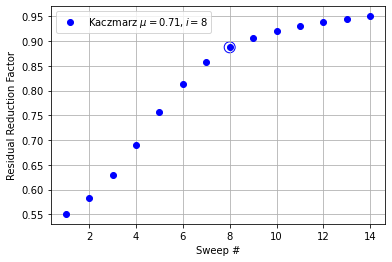

In [115]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]

In [116]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 2 ideal TVs


### Coarsening: Fixed (4/2)

In [117]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

[[-0.42  -0.571 -0.57  -0.416]
 [-0.663 -0.241  0.245  0.665]]


,0,1,2,3,4,5,6,7,8,9
0,-0.42,-0.57,-0.57,-0.42,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.66,-0.24,0.24,0.67,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.42,-0.57,-0.57,-0.42,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.66,-0.24,0.24,0.67,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.42,-0.57


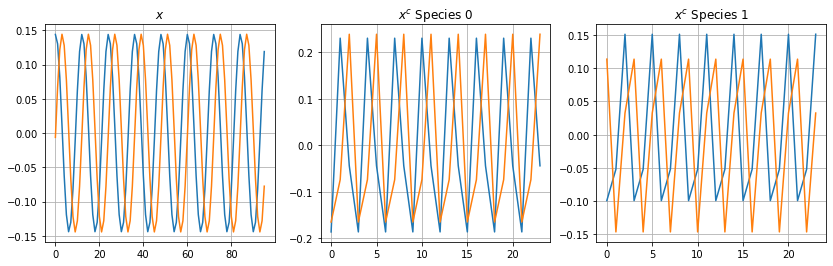

In [118]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [119]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.463 0.289 0.178 0.131 0.143 0.105 0.083 0.073]


### Interpolation $P = R^T$

In [120]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()
print(p.todense())

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "Two-level")).transpose()
display(conv)

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

[[-0.42  -0.663]
 [-0.571 -0.241]
 [-0.57   0.245]
 [-0.416  0.665]]


,1,2,3,4,5,6,7,8
Mock,0.46,0.29,0.18,0.13,0.14,0.11,0.08,0.07
Two-level,0.51,0.36,0.38,0.41,0.37,0.37,0.37,0.36


INFO     L2 projection norm 1.00 A*A' projection norm 2.83


This intepolation is good up to $\nu = 2$, conv $\approx 0.5$.

### Interpolation by LS Fitting

In [121]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber)
        print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))

        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, 
                    use_r_as_restriction=use_r_as_restriction), 
                nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append(two_level_conv)
        p_caliber.append(p)
    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

    conv = pd.DataFrame(np.array([mock_conv] + l2c).transpose(), 
                        index=nu_values, columns=("Mock",) + tuple("Caliber {}".format(caliber)
                                                                  for caliber in calibers)).transpose()
    display(conv)

P^T*A*P
INFO     caliber 2 error l2 [0.00] a [9.99e-01]
p row sums [-1.082 -0.813 -0.325  0.25  -1.082]
INFO     caliber 3 error l2 [0.00] a [9.64e-01]
p row sums [-1.09  -0.809 -0.195  0.12  -1.09 ]
INFO     caliber 4 error l2 [0.00] a [9.13e-01]
p row sums [-0.949 -0.879 -0.057  0.005 -0.949]


,1,2,3,4,5,6,7,8
Mock,0.46,0.29,0.18,0.13,0.14,0.11,0.08,0.07
Caliber 2,0.51,0.36,0.39,0.42,0.35,0.36,0.35,0.35
Caliber 3,0.60,0.35,0.29,0.34,0.29,0.26,0.26,0.26
Caliber 4,0.62,0.26,0.17,0.21,0.19,0.14,0.12,0.12


R*A*P
INFO     caliber 2 error l2 [0.00] a [9.99e-01]
p row sums [-1.082 -0.813 -0.325  0.25  -1.082]
INFO     caliber 3 error l2 [0.00] a [9.64e-01]
p row sums [-1.09  -0.809 -0.195  0.12  -1.09 ]
INFO     caliber 4 error l2 [0.00] a [9.13e-01]
p row sums [-0.949 -0.879 -0.057  0.005 -0.949]


,1,2,3,4,5,6,7,8
Mock,0.46,0.29,0.18,0.13,0.14,0.11,0.08,0.07
Caliber 2,0.51,0.35,0.39,0.42,0.35,0.35,0.33,0.35
Caliber 3,0.58,0.35,0.32,0.36,0.31,0.29,0.30,0.29
Caliber 4,0.59,0.26,0.19,0.24,0.21,0.17,0.17,0.17


In [122]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, None, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} nnz(P) {} fill-in {:.2f}".format(caliber, p.nnz, (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])))
        print("Max abs |Ac - Ac^T| {:.3e}".format(np.max(np.abs(ac - ac.transpose()))))
        display_df_side_by_side(pd.DataFrame(p[:6, :6].todense()),
                                pd.DataFrame(ac.todense()[:10,:10]), 
                            captions=("P", "A^1"))

P^T*A*P
caliber 2 nnz(P) 192 fill-in 1.20
Max abs |Ac - Ac^T| 1.110e-16


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.42 
 -0.66 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.57 
 -0.24 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.57 
 0.24 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.42 
 0.67 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 -0.42 
 -0.66 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 -0.57 
 -0.24 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.17 
 -0.00 
 0.19 
 0.33 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.00 
 -1.47 
 -0.33 
 -0.56 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.19 
 -0.33 
 -0.17 
 -0.00 
 0.19 
 0.33 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.33 
 -0.56 
 -0.00 
 -1.47 
 -0.33 
 -0.56 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.19 
 -0.33 
 -0.17 
 -0.00 
 0.19 
 0.33 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.33 
 -0.56 
 -0.00 
 -1.47 
 -0.33 
 -0.56 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.19 
 -0.33 
 -0.17 
 -0.00 
 0.19 
 0.33 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 0.33 
 -0.56 
 -0.00 
 -1.47 
 -0.33 
 -0.56 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.19 
 -0.33 
 -0.17 
 -0.00 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.33 
 -0.56 
 -0.00 
 -1.47

caliber 3 nnz(P) 288 fill-in 1.40
Max abs |Ac - Ac^T| 1.180e-16


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.45 
 -0.57 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.56 
 -0.28 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.55 
 0.31 
 0.04 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.44 
 0.60 
 -0.05 
 0.00 
 0.00 
 0.00 
 
 
 4 
 -0.07 
 0.00 
 -0.45 
 -0.57 
 0.00 
 0.00 
 
 
 5 
 0.03 
 0.00 
 -0.56 
 -0.28 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.10 
 -0.02 
 0.19 
 0.25 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.02 
 -1.17 
 -0.29 
 -0.43 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.19 
 -0.29 
 -0.10 
 -0.02 
 0.19 
 0.25 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.25 
 -0.43 
 -0.02 
 -1.17 
 -0.29 
 -0.43 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.19 
 -0.29 
 -0.10 
 -0.02 
 0.19 
 0.25 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.25 
 -0.43 
 -0.02 
 -1.17 
 -0.29 
 -0.43 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.19 
 -0.29 
 -0.10 
 -0.02 
 0.19 
 0.25 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 0.25 
 -0.43 
 -0.02 
 -1.17 
 -0.29 
 -0.43 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.19 
 -0.29 
 -0.10 
 -0.02 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.25 
 -0.43 
 -0.02 
 -1.17

caliber 4 nnz(P) 384 fill-in 2.00
Max abs |Ac - Ac^T| 6.939e-17


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.42 
 -0.52 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.57 
 -0.31 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.58 
 0.38 
 0.06 
 0.09 
 0.00 
 0.00 
 
 
 3 
 -0.41 
 0.55 
 -0.06 
 -0.07 
 0.00 
 0.00 
 
 
 4 
 -0.08 
 0.07 
 -0.42 
 -0.52 
 0.00 
 0.00 
 
 
 5 
 0.04 
 -0.03 
 -0.57 
 -0.31 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.07 
 -0.02 
 0.17 
 0.21 
 0.00 
 0.01 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.02 
 -0.93 
 -0.25 
 -0.32 
 -0.00 
 -0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.17 
 -0.25 
 -0.07 
 -0.02 
 0.17 
 0.21 
 0.00 
 0.01 
 0.00 
 0.00 
 
 
 3 
 0.21 
 -0.32 
 -0.02 
 -0.93 
 -0.25 
 -0.32 
 -0.00 
 -0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 -0.00 
 0.17 
 -0.25 
 -0.07 
 -0.02 
 0.17 
 0.21 
 0.00 
 0.01 
 
 
 5 
 0.01 
 -0.00 
 0.21 
 -0.32 
 -0.02 
 -0.93 
 -0.25 
 -0.32 
 -0.00 
 -0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 -0.00 
 0.17 
 -0.25 
 -0.07 
 -0.02 
 0.17 
 0.21 
 
 
 7 
 0.00 
 0.00 
 0.01 
 -0.00 
 0.21 
 -0.32 
 -0.02 
 -0.93 
 -0.25 
 -0.32 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.00 
 0.17 
 -0.25 
 -0.07 
 -0.02 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.01 
 -0.00 
 0.21 
 -0.32 
 -0.02 
 -0.93

R*A*P
caliber 2 nnz(P) 192 fill-in 1.20
Max abs |Ac - Ac^T| 1.110e-15


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.42 
 -0.66 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.57 
 -0.24 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.57 
 0.24 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.42 
 0.67 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 -0.42 
 -0.66 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 -0.57 
 -0.24 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.17 
 -0.00 
 0.19 
 0.33 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.00 
 -1.47 
 -0.33 
 -0.56 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.19 
 -0.33 
 -0.17 
 -0.00 
 0.19 
 0.33 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.33 
 -0.56 
 -0.00 
 -1.47 
 -0.33 
 -0.56 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.19 
 -0.33 
 -0.17 
 -0.00 
 0.19 
 0.33 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.33 
 -0.56 
 -0.00 
 -1.47 
 -0.33 
 -0.56 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.19 
 -0.33 
 -0.17 
 -0.00 
 0.19 
 0.33 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 0.33 
 -0.56 
 -0.00 
 -1.47 
 -0.33 
 -0.56 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.19 
 -0.33 
 -0.17 
 -0.00 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.33 
 -0.56 
 -0.00 
 -1.47

caliber 3 nnz(P) 288 fill-in 1.20
Max abs |Ac - Ac^T| 3.561e-02


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.45 
 -0.57 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.56 
 -0.28 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.55 
 0.31 
 0.04 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.44 
 0.60 
 -0.05 
 0.00 
 0.00 
 0.00 
 
 
 4 
 -0.07 
 0.00 
 -0.45 
 -0.57 
 0.00 
 0.00 
 
 
 5 
 0.03 
 0.00 
 -0.56 
 -0.28 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.12 
 0.00 
 0.20 
 0.28 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.03 
 -1.29 
 -0.31 
 -0.48 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.19 
 -0.30 
 -0.12 
 0.00 
 0.20 
 0.28 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.27 
 -0.50 
 -0.03 
 -1.29 
 -0.31 
 -0.48 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.19 
 -0.30 
 -0.12 
 0.00 
 0.20 
 0.28 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.27 
 -0.50 
 -0.03 
 -1.29 
 -0.31 
 -0.48 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.19 
 -0.30 
 -0.12 
 0.00 
 0.20 
 0.28 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 0.27 
 -0.50 
 -0.03 
 -1.29 
 -0.31 
 -0.48 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.19 
 -0.30 
 -0.12 
 0.00 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.27 
 -0.50 
 -0.03 
 -1.29

caliber 4 nnz(P) 384 fill-in 1.20
Max abs |Ac - Ac^T| 2.949e-02


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.42 
 -0.52 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.57 
 -0.31 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.58 
 0.38 
 0.06 
 0.09 
 0.00 
 0.00 
 
 
 3 
 -0.41 
 0.55 
 -0.06 
 -0.07 
 0.00 
 0.00 
 
 
 4 
 -0.08 
 0.07 
 -0.42 
 -0.52 
 0.00 
 0.00 
 
 
 5 
 0.04 
 -0.03 
 -0.57 
 -0.31 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.09 
 0.00 
 0.18 
 0.24 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.03 
 -1.03 
 -0.26 
 -0.35 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.17 
 -0.25 
 -0.09 
 0.00 
 0.18 
 0.24 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.23 
 -0.37 
 -0.03 
 -1.03 
 -0.26 
 -0.35 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.17 
 -0.25 
 -0.09 
 0.00 
 0.18 
 0.24 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.23 
 -0.37 
 -0.03 
 -1.03 
 -0.26 
 -0.35 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.17 
 -0.25 
 -0.09 
 0.00 
 0.18 
 0.24 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 0.23 
 -0.37 
 -0.03 
 -1.03 
 -0.26 
 -0.35 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.17 
 -0.25 
 -0.09 
 0.00 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.23 
 -0.37 
 -0.03 
 -1.03

$R A P$ is nearly symmetric, and is sparser than $P^T A P$, while giving almost the same 2-level convergence factors for $\nu \geq 2$.

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 1.997e+01 RER 3.57057
INFO         1 |r| 2.404e+00 (0.12038) RER 0.24925 (0.06981) 9.647
INFO         2 |r| 3.600e-01 (0.14972) RER 0.02318 (0.09301) 15.530
INFO         3 |r| 6.358e-02 (0.17660) RER 0.00279 (0.12031) 22.796
INFO         4 |r| 1.227e-02 (0.19297) RER 0.00039 (0.13884) 31.683
INFO         5 |r| 2.432e-03 (0.19823) RER 0.00005 (0.12979) 48.389
INFO         6 |r| 4.885e-04 (0.20088) RER 0.00001 (0.15629) 62.195
INFO         7 |r| 9.832e-05 (0.20126) RER 0.00000 (0.34174) 36.628
INFO         8 |r| 1.991e-05 (0.20251) RER 0.00000 (0.28180) 26.321
INFO         9 |r| 4.052e-06 (0.20353) RER 0.00000 (0.15191) 35.266
INFO        10 |r| 8.253e-07 (0.20367) RER 0.00000 (0.08059) 89.131
INFO        11 |r| 1.682e-07 (0.20383) RER 0.00000 (0.11409) 159.242
INFO        12 |r| 3.437e-08 (0.20431) RER 0.00000 (0.09152) 355.477
INFO        13 |r| 7.035e-09 (0.20468) RER 0.00000 (0.12230) 594.938
INFO        14 |r| 1.439e-09 (0.20454) RER 0.00000 (0.07748) 1570.470
INF

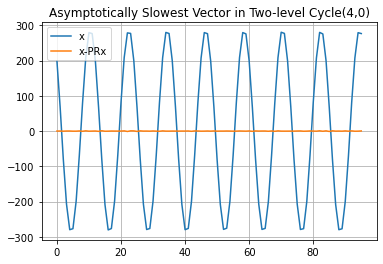

In [123]:
nu = 4
p = p_experiment[False][-1]
multilevel = hm.repetitive.locality.create_two_level_hierarchy(
    kh, discretization, n, R, p, aggregate_size, use_r_as_restriction=False)
y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
                                                   debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [124]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.153 -0.153  0.168  0.168]


#### $P^T A Q$ Coarsening
This is not exactly $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil.

In [125]:
caliber = 4
max_caliber = 6

a = multilevel.finest_level.a
p = multilevel[1].p
nc = num_components
num_aggregates = int(np.ceil(a.shape[0] / aggregate_size))
num_coarse_vars = nc * num_aggregates
nbhr = np.mod(hm.setup.interpolation.geometric_neighbors(aggregate_size, nc), num_coarse_vars)

# Prepare fine and coarse test matrices.
xc = R.dot(x)
residual = a.dot(x)

max_caliber = min(max_caliber, max(len(n) for n in nbhr))
x_disjoint_aggregate_t, xc_disjoint_aggregate_t, r_norm_disjoint_aggregate_t = \
    hm.setup.sampling.get_disjoint_windows(x, xc, residual, aggregate_size, nc, max_caliber)
weight = np.clip(r_norm_disjoint_aggregate_t, 1e-15, None) ** (-1)

nbhr_for_caliber = [n[:caliber] for n in nbhr]
q = hm.setup.interpolation_ls_fit.create_interpolation_least_squares_weighted(
    x_disjoint_aggregate_t, xc_disjoint_aggregate_t, nbhr_for_caliber, weight=weight)


In [126]:
coarse_vars = np.unique(q.nonzero()[1])
print(coarse_vars)
pd.DataFrame(q[:, coarse_vars].todense())

[ 0  1  2  3 46 47]


,0,1,2,3,4,5
0,-0.34,-0.25,0.00,0.00,-0.18,0.31
1,-0.40,-0.13,0.00,0.00,0.02,0.29
2,-0.40,0.13,0.02,-0.29,0.00,0.00
3,-0.34,0.26,-0.18,-0.31,0.00,0.00


In [127]:
pta = p.transpose().dot(a)
pd.DataFrame(pta.todense()[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,0.14,-0.03,0.03,0.07,-0.27,-0.16,0.06,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,0.09,-0.19,-0.29
1,0.60,0.47,-0.49,-0.59,0.49,0.12,-0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,0.12,-0.24,-0.40
2,-0.01,0.09,-0.19,-0.29,0.14,-0.03,0.03,0.07,-0.27,-0.16,0.06,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.01,0.12,-0.24,-0.40,0.60,0.47,-0.49,-0.59,0.49,0.12,-0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,-0.01,0.09,-0.19,-0.29,0.14,-0.03,0.03,0.07,-0.27,-0.16,0.06,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [128]:
pta[0]

<1x96 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Column format>